# 1) Setup & Imports

In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2) Data Preparation

In [8]:
CSV_PATH = '/content/drive/My Drive/apartments_for_rent_classified_10K.csv'
df = pd.read_csv(CSV_PATH, sep=None, engine="python", encoding="cp1252")

df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r"\s+", "_", regex=True))

df.drop(columns=["price_display"], errors="ignore", inplace=True)

def _extract_price(series: pd.Series, frame_len: int) -> pd.Series:
    if series is None:
        return pd.Series([np.nan]*frame_len)
    return (series.astype(str)
                 .str.replace(",", "", regex=False)
                 .str.extract(r"(\d{3,6})")[0]
                 .astype("float64"))

if "price" not in df.columns:
    candidate = None
    for col in ["title", "body"]:
        if col in df.columns:
            tmp = _extract_price(df[col], len(df))
            if tmp.notna().sum() > 0:
                candidate = tmp
                break
    if candidate is None:
        raise ValueError("No 'price' column and could not extract from text.")
    df["price"] = candidate

df = df[pd.to_numeric(df["price"], errors="coerce").notna()].copy()
df["price"] = df["price"].astype(float)
df = df[(df["price"] >= 100) & (df["price"] <= 20000)].copy()

print("Shape after target cleaning:", df.shape)
display(df.head())



2. DATA PREPARATION
----------------------------------------
Shape after target cleaning: (9998, 21)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,790.0,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,425.0,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,1390.0,Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,925.0,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,880.0,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


# 3) Quick EDA


3. QUICK EDA
----------------------------------------


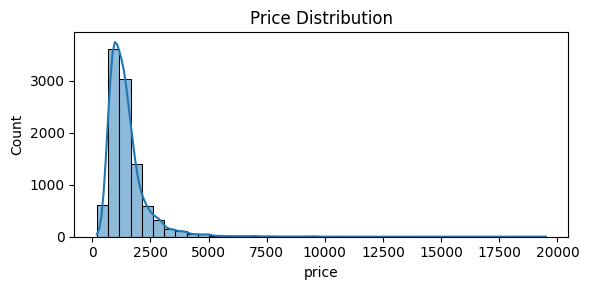

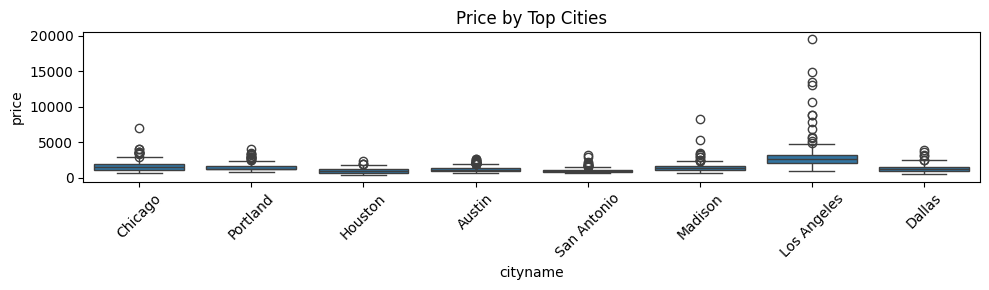

<class 'pandas.core.frame.DataFrame'>
Index: 9998 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9998 non-null   int64  
 1   category      9998 non-null   object 
 2   title         9998 non-null   object 
 3   body          9998 non-null   object 
 4   amenities     6450 non-null   object 
 5   bathrooms     9964 non-null   float64
 6   bedrooms      9991 non-null   float64
 7   currency      9998 non-null   object 
 8   fee           9998 non-null   object 
 9   has_photo     9998 non-null   object 
 10  pets_allowed  5837 non-null   object 
 11  price         9998 non-null   float64
 12  price_type    9998 non-null   object 
 13  square_feet   9998 non-null   int64  
 14  address       6671 non-null   object 
 15  cityname      9921 non-null   object 
 16  state         9921 non-null   object 
 17  latitude      9988 non-null   float64
 18  longitude     9988 non-null   flo

In [9]:
plt.figure(figsize=(6,3))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Price Distribution")
plt.tight_layout()
plt.show()

if "cityname" in df.columns:
    top_cities = df["cityname"].value_counts().head(8).index
    plt.figure(figsize=(10,3))
    sns.boxplot(x="cityname", y="price", data=df[df["cityname"].isin(top_cities)])
    plt.xticks(rotation=45)
    plt.title("Price by Top Cities")
    plt.tight_layout()
    plt.show()

print(df.info())


# 4) Feature Engineering

In [10]:
class ApartmentFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, use_new_features=True):
        self.use_new_features = use_new_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        if self.use_new_features:
            if "square_feet" in X_trans.columns:
                sqft_filled = X_trans["square_feet"].replace(0, np.nan).fillna(X_trans["square_feet"].median())
                X_trans["log_sqft"] = np.log1p(sqft_filled)

            if "amenities" in X_trans.columns:
                amenities = X_trans["amenities"].fillna("")
                X_trans["amenity_count"] = amenities.apply(lambda x: len([a for a in x.split(",") if a.strip()]))
                X_trans["has_parking"] = amenities.str.contains("Parking|Garage", case=False).astype(int)

        return X_trans


# 5) Train/Test Split & Preprocessing

In [11]:
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_tf, X_train.select_dtypes(include=[np.number]).columns.tolist()),
    ("cat", cat_tf, [c for c in X_train.columns if c not in X_train.select_dtypes(include=[np.number]).columns])
])


# 6) KNN Model Training

In [12]:
knn_pipe = Pipeline([
    ("feature_eng", ApartmentFeatureEngineer()),
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor())
])

knn_params = {
    "feature_eng__use_new_features": [True, False],
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

knn_search = RandomizedSearchCV(
    estimator=knn_pipe,
    param_distributions=knn_params,
    n_iter=20,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)

print("Training KNN Regressor with hyperparameter tuning...")
knn_search.fit(X_train, y_train)


Training KNN Regressor with hyperparameter tuning...


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('feature_eng',
                                              ApartmentFeatureEngineer()),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['id',
                                                                                'bathrooms',
                                                                                'bedrooms',
                                                                                'square_feet',
                                                                                'latitude',
                                                                                'longitude',
                                                                                'time']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Si...
                                                                                'currency',
                                                                                'fee',
                                                                                'has_photo',
                                                                                'pets_allowed',
                                                                                'price_type',
                                                                                'address',
                                                                                'cityname',
                                                                                'state',
                                                                                'source'])])),
                                             ('knn', KNeighborsRegressor())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'feature_eng__use_new_features': [True,
                                                                          False],
                                        'knn__n_neighbors': [3, 5, 7, 9, 11],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=42, scoring='neg_mean_squared_error')

# 7) Evaluation


KNN Best Parameters: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 7, 'feature_eng__use_new_features': True}
KNN MAE:  289.77
KNN RMSE: 557.25
KNN R²:   0.6211


,MAE,RMSE,R2
KNN,289.770648,557.2542,0.621053


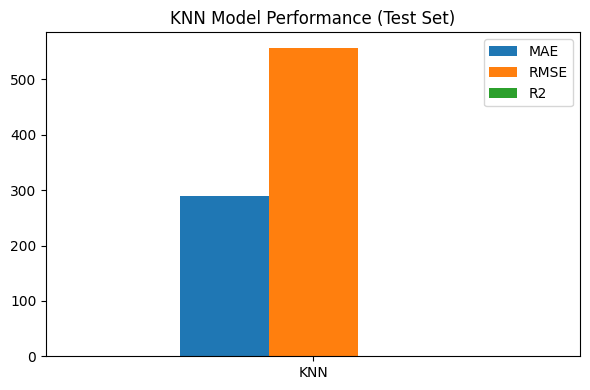

In [14]:
knn_best = knn_search.best_estimator_
y_pred_knn = knn_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_knn)
mse = mean_squared_error(y_test, y_pred_knn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_knn)

print("\nKNN Best Parameters:", knn_search.best_params_)
print(f"KNN MAE:  {mae:.2f}")
print(f"KNN RMSE: {rmse:.2f}")
print(f"KNN R²:   {r2:.4f}")

results = {}
results["KNN"] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
display(results_df)

ax = results_df[["MAE", "RMSE", "R2"]].plot(kind="bar", figsize=(6,4))
plt.title("KNN Model Performance (Test Set)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
